In [6]:
%matplotlib inline
import os
import pickle
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import dotenv
dotenv.load_dotenv()

True

In [7]:
plt.style.use('../style/style-formal.mplstyle')

In [8]:
RESEARCH_DATA = os.environ.get("RESEARCH_DATA")

EL = "attempt_1"
PIDS = ["Lang", "Mockito", "Math"]

SBFL_FORMULA = [
    "tarantula", "ochiai", "dstar",
    "naish1", "naish2", "gp13"
]

TRANSITION_TYPES = {
    "type1": "result_transition",
    "type2": "exception_type_transition",
    "type3": "exception_msg_transition",
    "type4": "stacktrace_transition",
    "type5": "all_types_transition"
}

curr_dir = os.getcwd()
root_dir = os.path.dirname(curr_dir)
dot_exp_config_file = os.path.join(root_dir, ".experiment_config")
EXP_CONFIG = json.load(open(dot_exp_config_file, "r"))

TCS_REDUCTION = EXP_CONFIG["tcs_reduction"]
TCS_EXP_LIST = ["All"]

if len(EXP_CONFIG["target_lines"]) > 1:
    EXPERIMENT_TYPE = "lineCnt"
elif len(EXP_CONFIG["mutation_cnt"]) > 1:
    EXPERIMENT_TYPE = "mutCnt"
else:
    EXPERIMENT_TYPE = "tcsReduction"
    TCS_EXP_LIST.append("Reduced")

TOP_N = [1, 3, 5, 10]

# Create output directories for each PID and a combined results directory
PID_OUT_DIRS = {}
for PID in PIDS:
    PID_OUT_DIR = os.path.join(RESEARCH_DATA, EL, PID, "experiment_information_results")
    if not os.path.exists(PID_OUT_DIR):
        os.makedirs(PID_OUT_DIR, exist_ok=True)
    PID_OUT_DIRS[PID] = PID_OUT_DIR

# Create a combined results directory
COMBINED_OUT_DIR = os.path.join(RESEARCH_DATA, EL, "combined_experiment_results")
if not os.path.exists(COMBINED_OUT_DIR):
    os.makedirs(COMBINED_OUT_DIR, exist_ok=True)

print(f"Processing {len(PIDS)} projects: {PIDS}")
print(f"Individual project results will be saved to respective directories")
print(f"Combined results will be saved to: {COMBINED_OUT_DIR}")

Processing 3 projects: ['Lang', 'Mockito', 'Math']
Individual project results will be saved to respective directories
Combined results will be saved to: /ssd_home/yangheechan/d4j_research_data/attempt_1/combined_experiment_results


In [9]:
# Faulty lines are indicated with 'fault_line' as value 1.

# res = {bid: {std: [rank of faulty_line: 1, rank of faulty_line: 2, ...] ...} ...}
# std are the sbfl formulas and mbfl formulas in TRANSITION_TYPES and MUT_RANGE

def set_faulty_line_ranks(total_results, lineIdx2lineData, bid):
    total_results[bid] = {}

    for sbfl_form in SBFL_FORMULA:
        for lineIdx, lineData in lineIdx2lineData.items():
            fault_line = lineData.get("fault_line")
            if fault_line == 1:
                sbfl_key = f"{sbfl_form}_rank"
                rank = lineData.get(sbfl_key)
                if sbfl_key not in total_results[bid]:
                    total_results[bid][sbfl_key] = []
                total_results[bid][sbfl_key].append(rank)

    for line_cnt in EXP_CONFIG["target_lines"]:
        for mut_cnt in EXP_CONFIG["mutation_cnt"]:
            for tcs_exp in TCS_EXP_LIST:
                for transition_type, transition_key in TRANSITION_TYPES.items():
                    for lineIdx, lineData in lineIdx2lineData.items():
                        fault_line = lineData.get("fault_line")
                        if fault_line == 1:
                            muse_key = f"lineCnt{line_cnt}_mutCnt{mut_cnt}_tcs{tcs_exp}_{transition_key}_final_muse_score_rank"
                            muse_rank = lineData.get(muse_key)
                            if muse_key not in total_results[bid]:
                                total_results[bid][muse_key] = []
                            total_results[bid][muse_key].append(muse_rank)
                            

                            metal_key = f"lineCnt{line_cnt}_mutCnt{mut_cnt}_tcs{tcs_exp}_{transition_key}_final_metal_score_rank"
                            metal_rank = lineData.get(metal_key)
                            if metal_key not in total_results[bid]:
                                total_results[bid][metal_key] = []
                            total_results[bid][metal_key].append(metal_rank)

In [10]:
# Process data for all PIDs
all_total_results = {}  # Structure: {PID: {rid: {bid: {technique: [ranks...]}}}}

for PID in PIDS:
    print(f"\nProcessing project: {PID}")
    total_results = {}
    
    for rid in range(1, EXP_CONFIG["num_repeats"] + 1):
        RID_dir = f"repeat_{rid}"
        total_results[RID_dir] = {}

        lineIdx2lineDataDir = os.path.join(RESEARCH_DATA, EL, PID, "experiment_raw_results", RID_dir)
        
        if not os.path.exists(lineIdx2lineDataDir):
            print(f"Warning: Directory not found for {PID} - {RID_dir}: {lineIdx2lineDataDir}")
            continue

        for bid_res_file in os.listdir(lineIdx2lineDataDir):
            pck_file = os.path.join(lineIdx2lineDataDir, bid_res_file)
            with open(pck_file, 'rb') as f:
                bid = int(bid_res_file.split("_")[0])
                lineIdx2lineData = pickle.load(f)
                set_faulty_line_ranks(total_results[RID_dir], lineIdx2lineData, bid)
    
    # Store results for this PID
    all_total_results[PID] = total_results
    
    # Save individual PID results
    with open(os.path.join(PID_OUT_DIRS[PID], f"{PID}_faulty_line_ranks.json"), 'w') as f:
        json.dump(total_results, f, indent=4)
    
    print(f"Completed processing {PID}: {len(total_results)} experimental runs")

print(f"\nCompleted processing all {len(PIDS)} projects")
print(f"Individual results saved for each project")


Processing project: Lang
Completed processing Lang: 10 experimental runs

Processing project: Mockito
Completed processing Mockito: 10 experimental runs

Processing project: Math
Completed processing Math: 10 experimental runs

Completed processing all 3 projects
Individual results saved for each project


In [11]:
# TOP-N: # of faults where at least one its faulty statement is located within top-N. (Top-1, Top-3, and Top-5, Top-10).
# MFR: average of ranks of the first faulty statement for all faults
# MAR: average rank of all faulty statements for each faults

def calculate_exp_results(total_results):
    """Calculate experimental results for all techniques efficiently"""
    default = {
        "topN": {n: 0 for n in TOP_N},
        "mfr_list": [],
        "mar_list": []
    }

    exp_results = {}
    
    # Process SBFL techniques
    for sbfl_form in SBFL_FORMULA:
        sbfl_key = f"{sbfl_form}_rank"
        exp_results[sbfl_key] = copy.deepcopy(default)

        for bid, result in total_results.items():
            ranks = result.get(sbfl_key, [])
            if ranks:  # Only process if ranks exist
                # Update TOP-N counts
                for n in TOP_N:
                    if any(rank <= n for rank in ranks):
                        exp_results[sbfl_key]["topN"][n] += 1

                # Update MFR and MAR
                exp_results[sbfl_key]["mfr_list"].append(min(ranks))
                exp_results[sbfl_key]["mar_list"].extend(ranks)
    
    # Process MBFL techniques
    for line_cnt in EXP_CONFIG["target_lines"]:
        for mut_cnt in EXP_CONFIG["mutation_cnt"]:
            for tcs_exp in TCS_EXP_LIST:
                for transition_type, transition_key in TRANSITION_TYPES.items():
                    for technique in ["muse", "metal"]:
                        key = f"lineCnt{line_cnt}_mutCnt{mut_cnt}_tcs{tcs_exp}_{transition_key}_final_{technique}_score_rank"
                        exp_results[key] = copy.deepcopy(default)

                        for bid, result in total_results.items():
                            ranks = result.get(key, [])
                            if ranks:  # Only process if ranks exist
                                # Update TOP-N counts
                                for n in TOP_N:
                                    if any(rank <= n for rank in ranks):
                                        exp_results[key]["topN"][n] += 1

                                # Update MFR and MAR
                                exp_results[key]["mfr_list"].append(min(ranks))
                                exp_results[key]["mar_list"].extend(ranks)
    
    # Calculate averages efficiently
    for key, result in exp_results.items():
        if result["mfr_list"]:  # Avoid division by zero
            result["mfr"] = np.mean(result["mfr_list"])
            result["mar"] = np.mean(result["mar_list"])
        else:
            result["mfr"] = 0
            result["mar"] = 0

    return exp_results

In [12]:
# Calculate experimental results for all PIDs
print("Processing experimental results for all projects...")

# Structure: {PID: {rid: {technique: {topN, mfr, mar, ...}}}}
all_exp_results = {}

# Process each PID individually
for PID in PIDS:
    print(f"\nCalculating experimental results for {PID}...")
    
    total_exp_results = {}
    for rid_key, rid_results in all_total_results[PID].items():
        exp_results = calculate_exp_results(rid_results)
        total_exp_results[rid_key] = exp_results
    
    all_exp_results[PID] = total_exp_results
    print(f"Processed {len(total_exp_results)} experimental runs for {PID}")

print(f"\nCompleted experimental results calculation for all {len(PIDS)} projects")

Processing experimental results for all projects...

Calculating experimental results for Lang...
Processed 10 experimental runs for Lang

Calculating experimental results for Mockito...
Processed 10 experimental runs for Mockito

Calculating experimental results for Math...
Processed 10 experimental runs for Math

Completed experimental results calculation for all 3 projects


In [13]:
def calculate_average_results_across_runs(total_exp_results):
    """Calculate average results across all experimental runs for each technique"""
    
    # Get all technique keys from the first run
    first_run_key = list(total_exp_results.keys())[0]
    all_technique_keys = list(total_exp_results[first_run_key].keys())
    
    # Initialize aggregated results structure
    aggregated_results = {
        technique_key: {
            "topN_all_runs": {n: [] for n in TOP_N},
            "mfr_all_runs": [],
            "mar_all_runs": []
        } for technique_key in all_technique_keys
    }
    
    # Collect data from all runs efficiently
    for run_key, run_results in total_exp_results.items():
        for technique_key in all_technique_keys:
            if technique_key in run_results:
                technique_data = run_results[technique_key]
                
                # Collect TopN, MFR and MAR data
                for n in TOP_N:
                    aggregated_results[technique_key]["topN_all_runs"][n].append(technique_data["topN"][n])
                
                aggregated_results[technique_key]["mfr_all_runs"].append(technique_data["mfr"])
                aggregated_results[technique_key]["mar_all_runs"].append(technique_data["mar"])
    
    # Calculate final statistics
    final_results = {}
    for technique_key in all_technique_keys:
        final_results[technique_key] = {
            "topN_mean": {},
            "topN_std": {},
            "mfr_mean": 0,
            "mfr_std": 0,
            "mar_mean": 0,
            "mar_std": 0
        }
        
        # Calculate TopN statistics
        for n in TOP_N:
            values = aggregated_results[technique_key]["topN_all_runs"][n]
            final_results[technique_key]["topN_mean"][n] = np.mean(values)
            final_results[technique_key]["topN_std"][n] = np.std(values)
        
        # Calculate MFR and MAR statistics
        mfr_values = aggregated_results[technique_key]["mfr_all_runs"]
        final_results[technique_key]["mfr_mean"] = np.mean(mfr_values)
        final_results[technique_key]["mfr_std"] = np.std(mfr_values)
        
        mar_values = aggregated_results[technique_key]["mar_all_runs"]
        final_results[technique_key]["mar_mean"] = np.mean(mar_values)
        final_results[technique_key]["mar_std"] = np.std(mar_values)
    
    return final_results

def save_results_to_csv_for_pid(final_results, pid, out_dir, filename_suffix="comprehensive_results"):
    """Save the averaged results to CSV file for a specific PID"""
    
    data = []
    for technique_key, results in final_results.items():
        row = {
            "PID": pid,
            "Technique": technique_key,
            "Top-1_mean": results["topN_mean"][1],
            "Top-1_std": results["topN_std"][1],
            "Top-3_mean": results["topN_mean"][3],
            "Top-3_std": results["topN_std"][3],
            "Top-5_mean": results["topN_mean"][5],
            "Top-5_std": results["topN_std"][5],
            "Top-10_mean": results["topN_mean"][10],
            "Top-10_std": results["topN_std"][10],
            "MFR_mean": results["mfr_mean"],
            "MFR_std": results["mfr_std"],
            "MAR_mean": results["mar_mean"],
            "MAR_std": results["mar_std"]
        }
        data.append(row)
    
    df = pd.DataFrame(data)
    
    # Sort by technique type for better organization
    def sort_key(technique):
        if any(sbfl in technique for sbfl in SBFL_FORMULA):
            return (0, technique)  # SBFL techniques first
        else:
            return (1, technique)  # MBFL techniques second
    
    df['sort_key'] = df['Technique'].apply(sort_key)
    df = df.sort_values('sort_key').drop('sort_key', axis=1)
    
    # Save to CSV
    csv_path = os.path.join(out_dir, f"{pid}_{filename_suffix}.csv")
    df.to_csv(csv_path, index=False)
    
    print(f"Results for {pid} saved to: {csv_path}")
    return df

def calculate_combined_results_across_pids(all_final_results):
    """Calculate combined results across all PIDs
    - TopN metrics: Sum across all PIDs (since they represent counts)
    - MFR/MAR metrics: Average across all PIDs
    """
    
    # Get all technique keys from the first PID
    first_pid = list(all_final_results.keys())[0]
    all_technique_keys = list(all_final_results[first_pid].keys())
    
    # Initialize combined results structure
    combined_results = {}
    
    for technique_key in all_technique_keys:
        # Collect data from all PIDs
        topN_values = {n: [] for n in TOP_N}
        mfr_values = []
        mar_values = []
        
        for pid, pid_results in all_final_results.items():
            if technique_key in pid_results:
                # Collect TopN values (these are counts to be summed)
                for n in TOP_N:
                    topN_values[n].append(pid_results[technique_key]["topN_mean"][n])
                
                # Collect MFR and MAR values (these are averages to be averaged)
                mfr_values.append(pid_results[technique_key]["mfr_mean"])
                mar_values.append(pid_results[technique_key]["mar_mean"])
        
        # Calculate combined statistics
        combined_results[technique_key] = {
            "topN_mean": {},
            "topN_std": {},
            "mfr_mean": np.mean(mfr_values) if mfr_values else 0,
            "mfr_std": np.std(mfr_values) if mfr_values else 0,
            "mar_mean": np.mean(mar_values) if mar_values else 0,
            "mar_std": np.std(mar_values) if mar_values else 0
        }
        
        # Calculate TopN statistics - SUM for combined counts, STD for variance
        for n in TOP_N:
            if topN_values[n]:
                combined_results[technique_key]["topN_mean"][n] = np.sum(topN_values[n])  # SUM instead of MEAN
                combined_results[technique_key]["topN_std"][n] = np.std(topN_values[n])
            else:
                combined_results[technique_key]["topN_mean"][n] = 0
                combined_results[technique_key]["topN_std"][n] = 0
    
    return combined_results

def save_combined_results_to_csv(combined_final_results, all_final_results, out_dir):
    """Save combined results and individual PID results to CSV files"""
    
    # Save combined results
    combined_data = []
    for technique_key, results in combined_final_results.items():
        row = {
            "PID": "COMBINED",
            "Technique": technique_key,
            "Top-1_mean": results["topN_mean"][1],
            "Top-1_std": results["topN_std"][1],
            "Top-3_mean": results["topN_mean"][3],
            "Top-3_std": results["topN_std"][3],
            "Top-5_mean": results["topN_mean"][5],
            "Top-5_std": results["topN_std"][5],
            "Top-10_mean": results["topN_mean"][10],
            "Top-10_std": results["topN_std"][10],
            "MFR_mean": results["mfr_mean"],
            "MFR_std": results["mfr_std"],
            "MAR_mean": results["mar_mean"],
            "MAR_std": results["mar_std"]
        }
        combined_data.append(row)
    
    # Add individual PID results
    all_data = combined_data.copy()
    for pid, pid_results in all_final_results.items():
        for technique_key, results in pid_results.items():
            row = {
                "PID": pid,
                "Technique": technique_key,
                "Top-1_mean": results["topN_mean"][1],
                "Top-1_std": results["topN_std"][1],
                "Top-3_mean": results["topN_mean"][3],
                "Top-3_std": results["topN_std"][3],
                "Top-5_mean": results["topN_mean"][5],
                "Top-5_std": results["topN_std"][5],
                "Top-10_mean": results["topN_mean"][10],
                "Top-10_std": results["topN_std"][10],
                "MFR_mean": results["mfr_mean"],
                "MFR_std": results["mfr_std"],
                "MAR_mean": results["mar_mean"],
                "MAR_std": results["mar_std"]
            }
            all_data.append(row)
    
    # Create DataFrames
    df_combined = pd.DataFrame(combined_data)
    df_all = pd.DataFrame(all_data)
    
    # Sort function
    def sort_key(technique):
        if any(sbfl in technique for sbfl in SBFL_FORMULA):
            return (0, technique)
        else:
            return (1, technique)
    
    # Sort DataFrames
    df_combined['sort_key'] = df_combined['Technique'].apply(sort_key)
    df_combined = df_combined.sort_values('sort_key').drop('sort_key', axis=1)
    
    df_all['sort_key'] = df_all['Technique'].apply(sort_key)
    df_all = df_all.sort_values(['PID', 'sort_key']).drop('sort_key', axis=1)
    
    # Save to CSV files
    combined_csv_path = os.path.join(out_dir, "combined_comprehensive_results.csv")
    all_csv_path = os.path.join(out_dir, "all_projects_comprehensive_results.csv")
    
    df_combined.to_csv(combined_csv_path, index=False)
    df_all.to_csv(all_csv_path, index=False)
    
    print(f"Combined results saved to: {combined_csv_path}")
    print(f"All projects results saved to: {all_csv_path}")
    
    return df_all

In [14]:
# Calculate final averaged results for each PID individually
print("Calculating final averaged results for each project...")

# Structure: {PID: {technique: {topN_mean, topN_std, mfr_mean, mfr_std, mar_mean, mar_std}}}
all_final_results = {}

# Calculate results for each PID
for PID in PIDS:
    print(f"\nCalculating final results for {PID}...")
    final_results = calculate_average_results_across_runs(all_exp_results[PID])
    all_final_results[PID] = final_results
    
    # Save individual PID comprehensive results to CSV
    print(f"Saving comprehensive results for {PID}...")
    df_results = save_results_to_csv_for_pid(final_results, PID, PID_OUT_DIRS[PID], "comprehensive_results")
    print(f"Saved {len(df_results)} technique results for {PID}")

print(f"\nCompleted individual project results calculation")

# Calculate combined results across all PIDs
print("\nCalculating combined results across all projects...")
combined_final_results = calculate_combined_results_across_pids(all_final_results)

# Save combined comprehensive results to CSV
print("Saving combined comprehensive results...")
df_combined = save_combined_results_to_csv(combined_final_results, all_final_results, COMBINED_OUT_DIR)
print(f"Saved combined results with {len(df_combined)} technique entries")

Calculating final averaged results for each project...

Calculating final results for Lang...
Saving comprehensive results for Lang...
Results for Lang saved to: /ssd_home/yangheechan/d4j_research_data/attempt_1/Lang/experiment_information_results/Lang_comprehensive_results.csv
Saved 26 technique results for Lang

Calculating final results for Mockito...
Saving comprehensive results for Mockito...
Results for Mockito saved to: /ssd_home/yangheechan/d4j_research_data/attempt_1/Mockito/experiment_information_results/Mockito_comprehensive_results.csv
Saved 26 technique results for Mockito

Calculating final results for Math...
Saving comprehensive results for Math...
Results for Math saved to: /ssd_home/yangheechan/d4j_research_data/attempt_1/Math/experiment_information_results/Math_comprehensive_results.csv
Saved 26 technique results for Math

Completed individual project results calculation

Calculating combined results across all projects...
Saving combined comprehensive results...
Com

In [16]:
def plot_topN_line_graph(final_results, out_dir, pid="COMBINED", ylimit=30, experiment_type="mutCnt", 
                         lineCnt=None, mutCnt=None, tcsReduction=None):
    """Plot Top-N line graph for the given final results"""

    exp_list = []
    if experiment_type == "lineCnt":
        exp_list = EXP_CONFIG["target_lines"]
        title = "Impact of %LineSelection on Top-{}"
        xLabel = "% of lines selected"
    elif experiment_type == "mutCnt":
        exp_list = EXP_CONFIG["mutation_cnt"]
        title = "Impact of #Mutants on Top-{}"
        xLabel = "# of mutants per line"
    elif experiment_type == "tcsReduction":
        exp_list = TCS_EXP_LIST
        title = "Impact of TCS Reduction on Top-{}"
        xLabel = "TCS Reduction"

    mbfl_techniques = ["muse", "metal"]
    
    graphs_dir = os.path.join(out_dir, "graphs")
    if not os.path.exists(graphs_dir):
        os.makedirs(graphs_dir, exist_ok=True)
    
    results_amongst_mbfl = {
        "muse_topN": {n: [] for n in TOP_N},
        "metal_topN": {n: [] for n in TOP_N}
    }

    # only for mutCnt{}_result_transition_final_muse_score_rank
    # mutCnt{}_result_transition_final_metal_score_rank
    for mbfl_form in mbfl_techniques:
        for exp_cnt in exp_list:
            if experiment_type == "lineCnt":
                key = f"lineCnt{exp_cnt}_mutCnt{mutCnt}_tcs{tcsReduction}_result_transition_final_{mbfl_form}_score_rank"
            elif experiment_type == "mutCnt":
                key = f"lineCnt{lineCnt}_mutCnt{exp_cnt}_tcs{tcsReduction}_result_transition_final_{mbfl_form}_score_rank"
            elif experiment_type == "tcsReduction":
                key = f"lineCnt{lineCnt}_mutCnt{mutCnt}_tcs{exp_cnt}_result_transition_final_{mbfl_form}_score_rank"
            
            for n in TOP_N:
                results_amongst_mbfl[f"{mbfl_form}_topN"][n].append(final_results[key]["topN_mean"][n])

    # Plotting Top-N line graph
    for i, top_n in enumerate(TOP_N[:3], 1):
        muse_data = results_amongst_mbfl["muse_topN"][top_n]
        metal_data = results_amongst_mbfl["metal_topN"][top_n]

        muse = plt.plot(exp_list, muse_data, marker='x', label=f'MUSE', linewidth=2)
        metal = plt.plot(exp_list, metal_data, marker='x', label=f'METAL', linewidth=2)

        plt.ylim(0, ylimit)
        # plt.legend([muse[0], metal[0]], ['MUSE', 'METAL'], bbox_to_anchor=(1, 1), fontsize=12, title='MBFL', title_fontsize=12)
        plt.legend([muse[0], metal[0]], ['MUSE', 'METAL'], fontsize=12)
        plt.title(title.format(top_n), fontsize=17)
        plt.xlabel(xLabel, fontsize=15)
        plt.xticks(exp_list, fontsize=12)
        plt.ylabel(f'Top-{top_n}', fontsize=15)
        plt.yticks(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tick_params(axis='both', which='major', labelsize=12)

        plt.savefig(os.path.join(graphs_dir, f"{pid}_top{top_n}_line_graph-{experiment_type}.png"), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()


Plotting Top-N line graph for combined results...


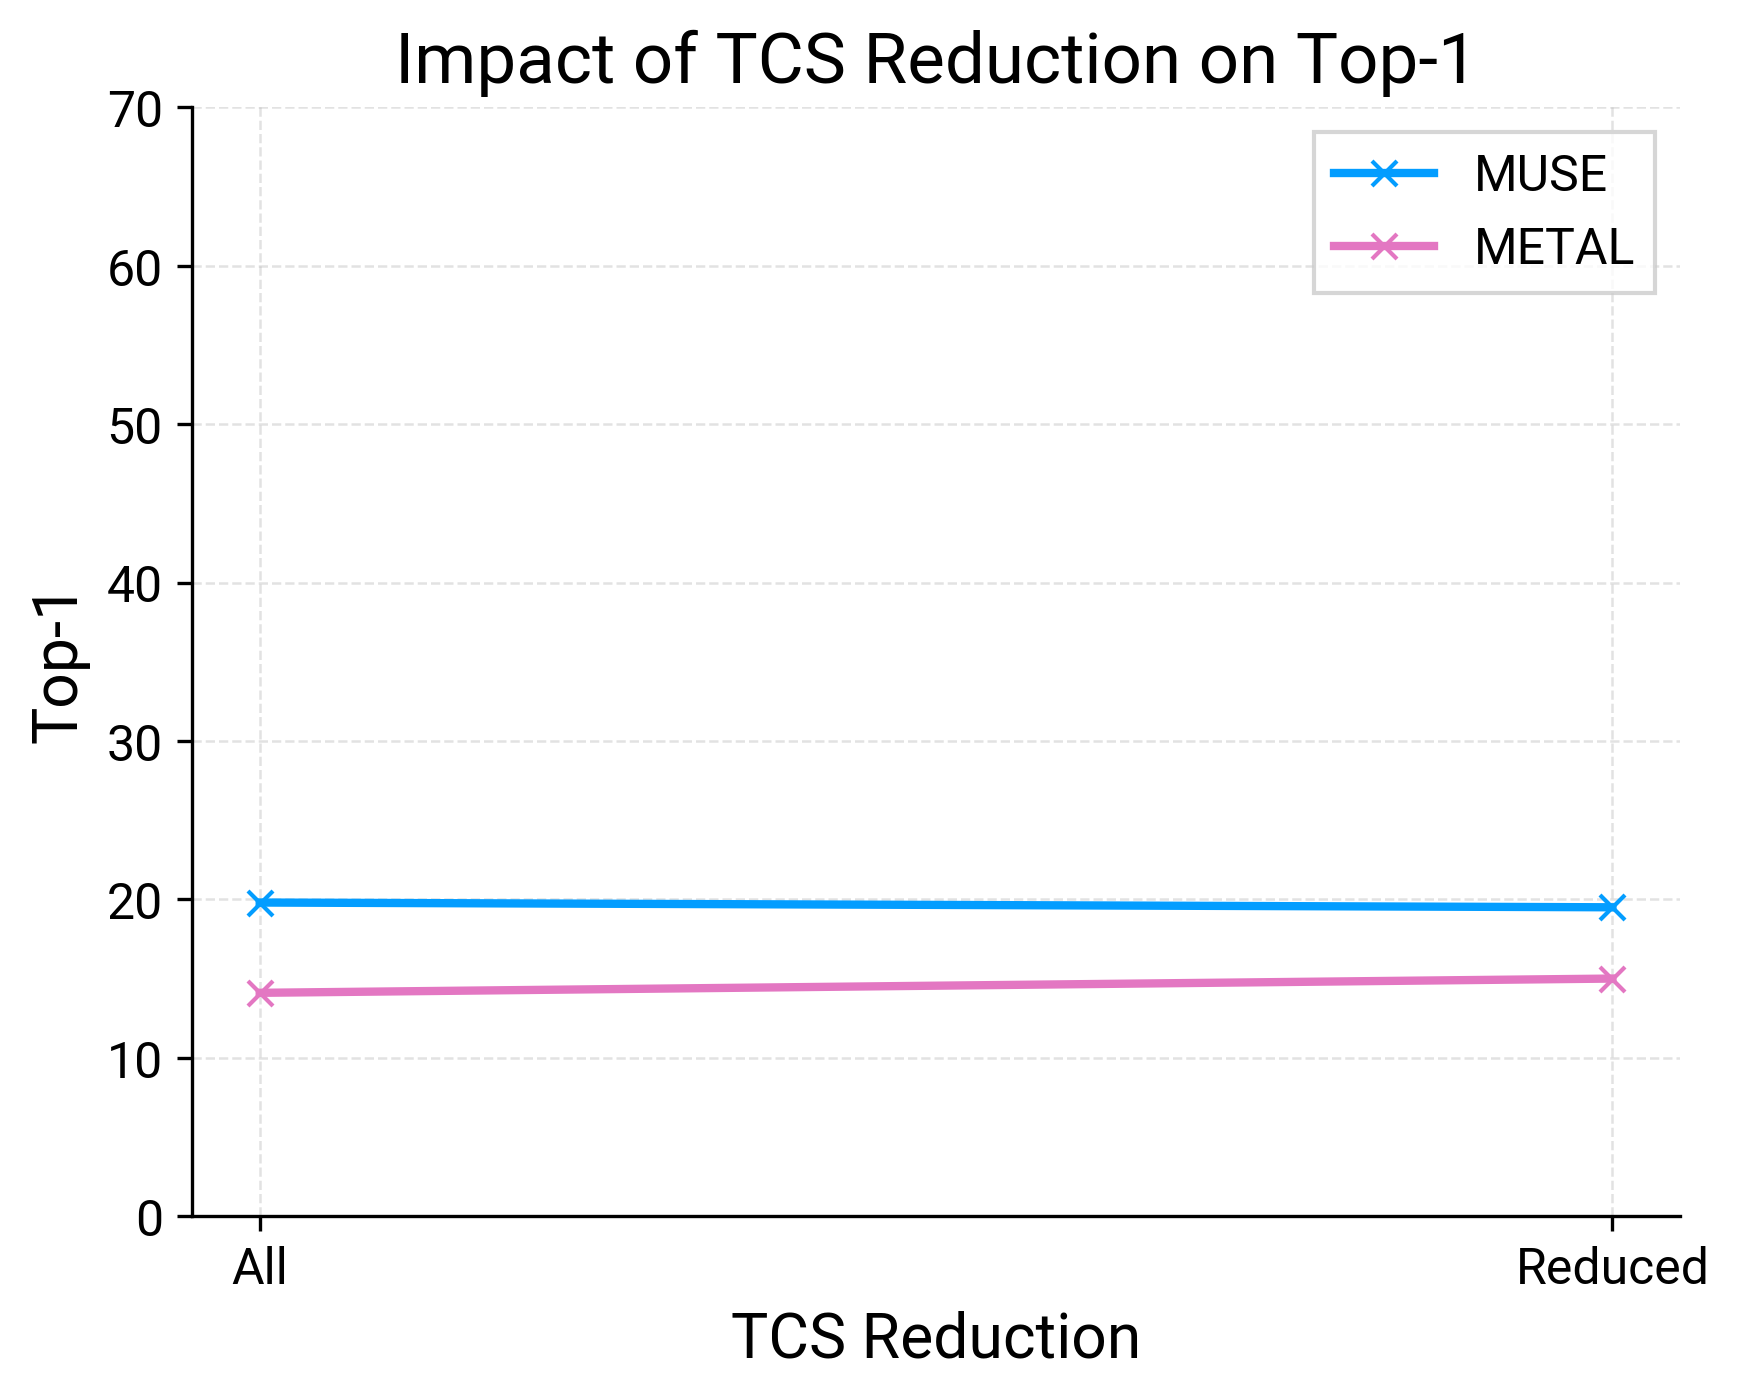

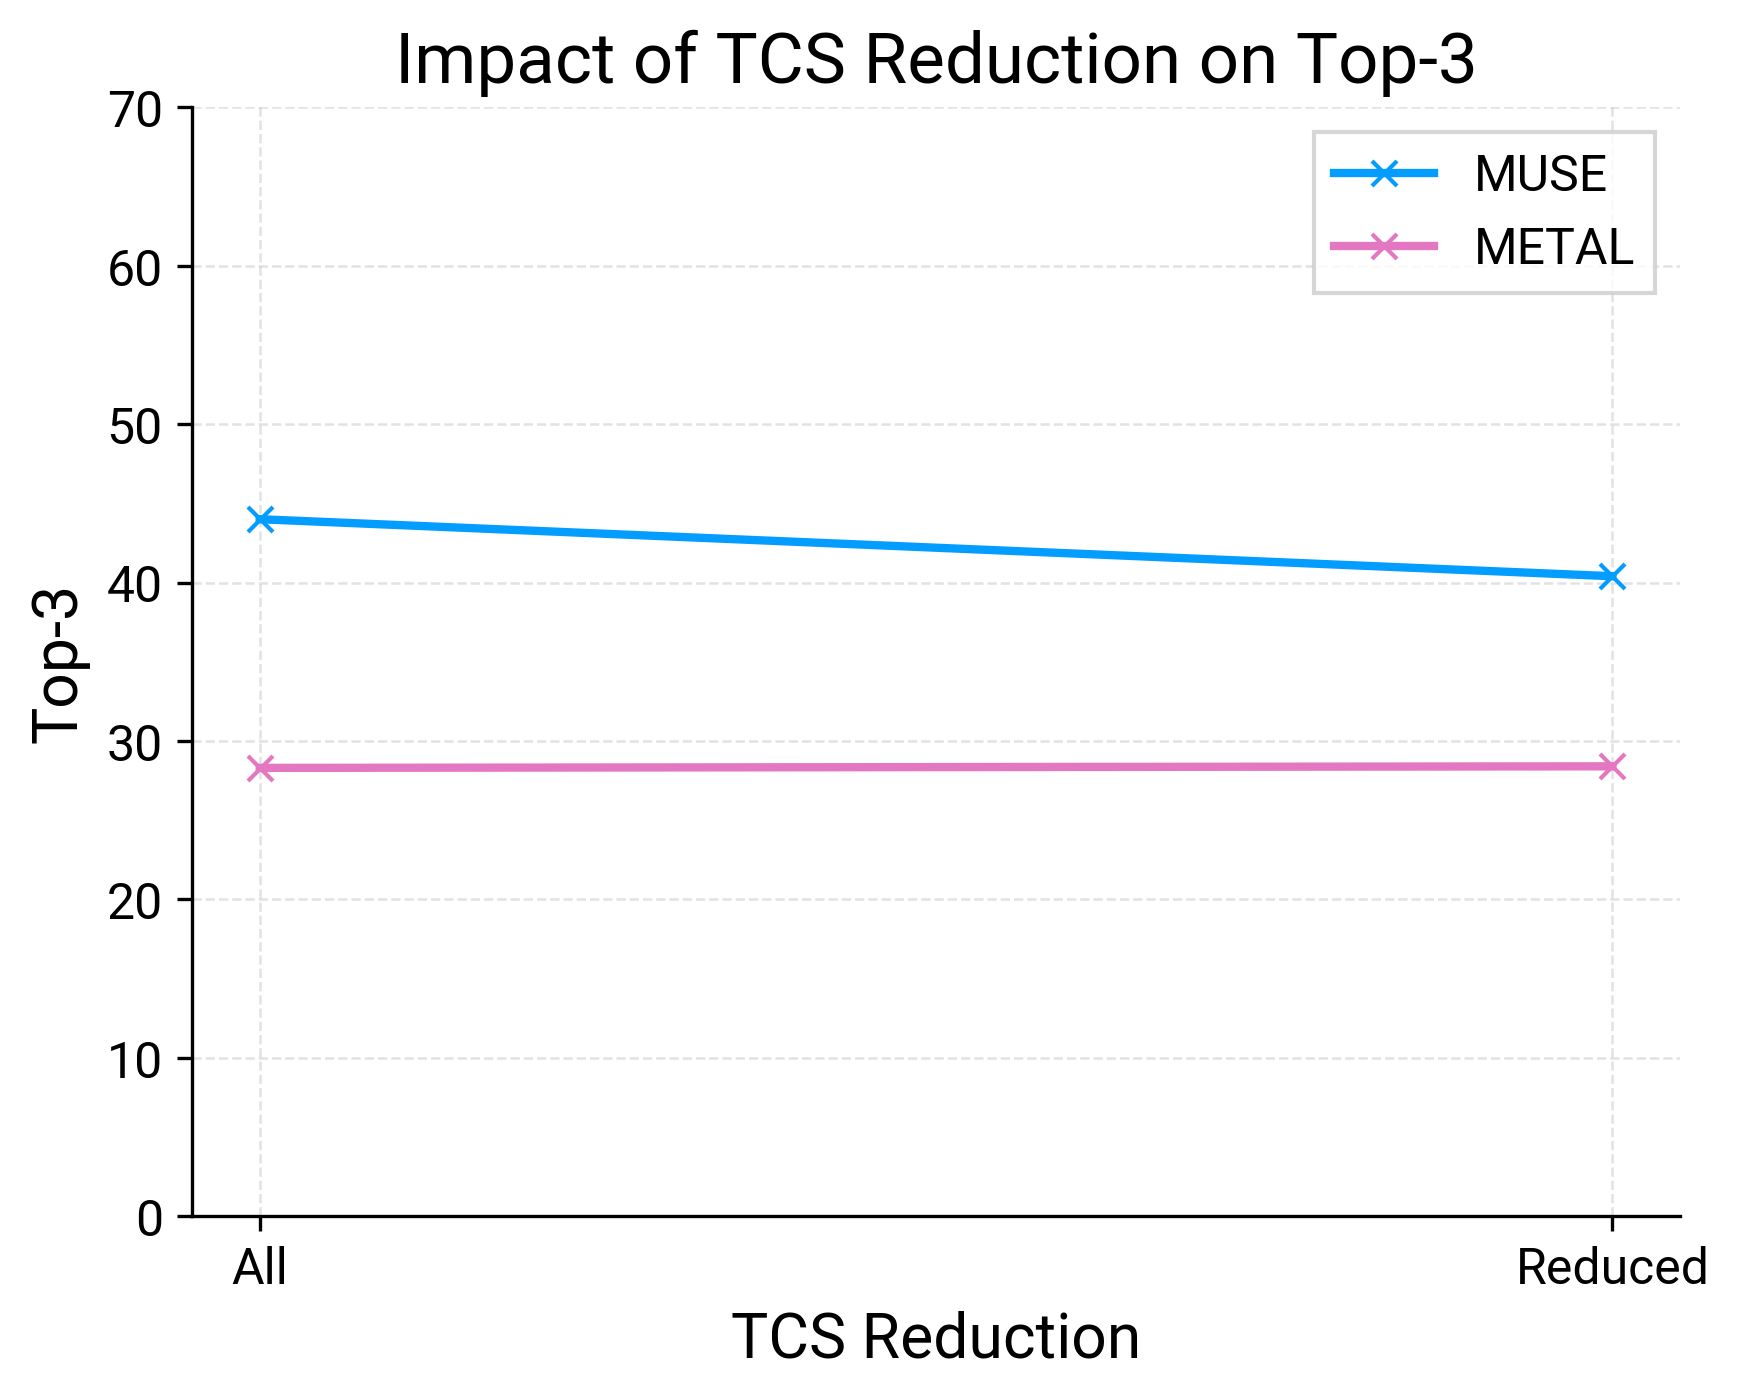

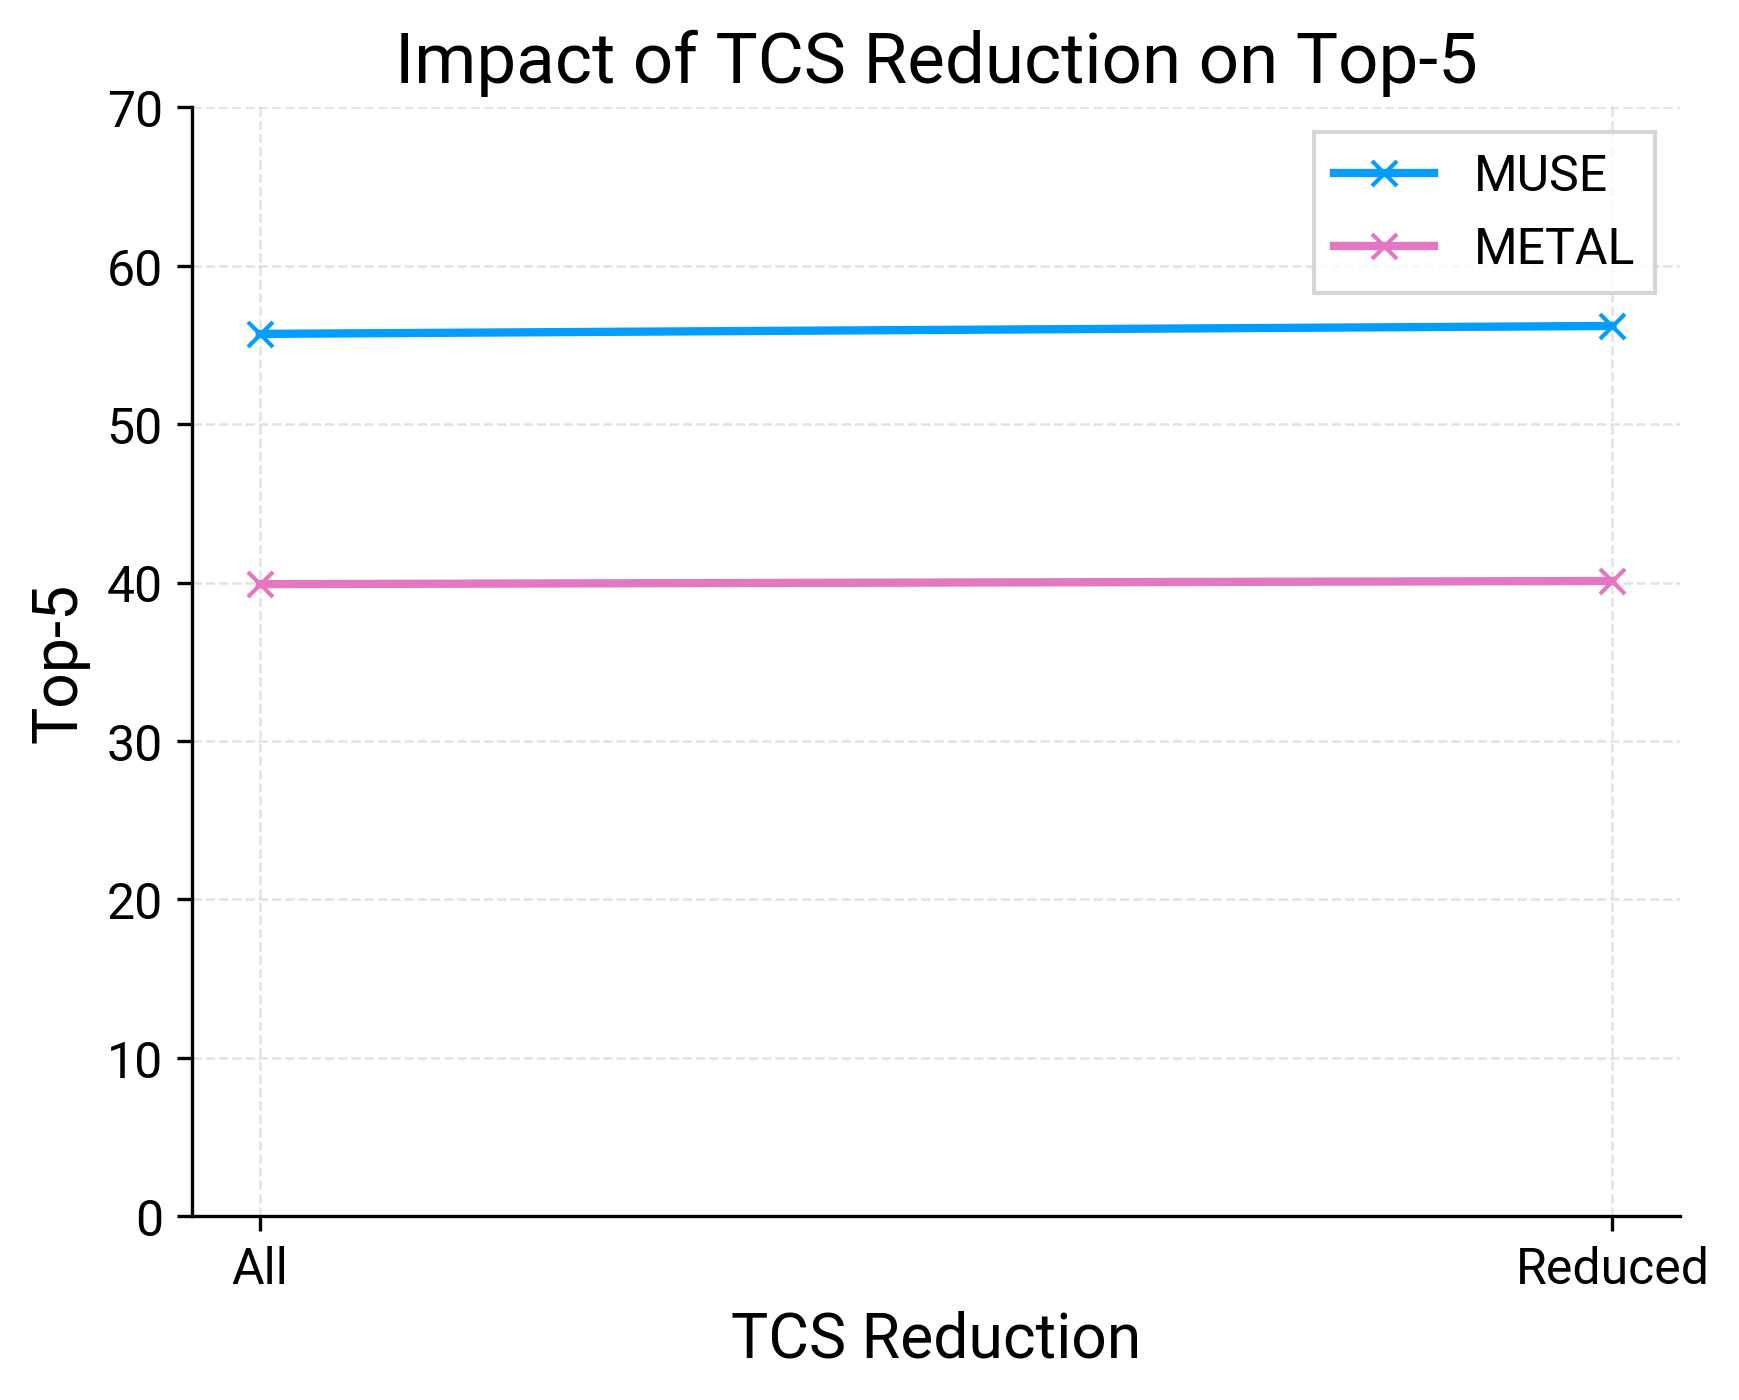

In [17]:
LIM_DATA = {
    "Lang": 30,
    "Mockito": 10,
    "Math": 30
}
# for PID in PIDS:
#     print(f"\nPlotting Top-N line graph for {PID}...")
#     plot_topN_line_graph(all_final_results[PID], PID_OUT_DIRS[PID], 
#                          pid=PID, ylimit=LIM_DATA[PID],
#                          experiment_type=EXPERIMENT_TYPE,
#                          lineCnt=EXP_CONFIG["target_lines"][-1],
#                          mutCnt=EXP_CONFIG["mutation_cnt"][-1],
#                          tcsReduction=TCS_REDUCTION
#                          )

print("\nPlotting Top-N line graph for combined results...")
plot_topN_line_graph(combined_final_results, COMBINED_OUT_DIR, pid="COMBINED", ylimit=70,
                     experiment_type=EXPERIMENT_TYPE, 
                     lineCnt=EXP_CONFIG["target_lines"][-1],
                     mutCnt=EXP_CONFIG["mutation_cnt"][-1],
                     tcsReduction=TCS_REDUCTION
                     )

In [18]:
def plot_mfr_mar_line_graphs(final_results, out_dir, pid="COMBINED", ylimit=100, experiment_type="mutCnt", 
                                lineCnt=None, mutCnt=None, tcsReduction=None):
    """Plot MFR and MAR line graphs for the given final results"""

    mbfl_techniques = ["muse", "metal"]

    if experiment_type == "lineCnt":
        exp_list = EXP_CONFIG["target_lines"]
        title_mfr = "Impact of %LineSelection on MFR"
        title_mar = "Impact of %LineSelection on MAR"
        xLabel = "% of lines selected"
    elif experiment_type == "mutCnt":
        exp_list = EXP_CONFIG["mutation_cnt"]
        title_mfr = "Impact of #Mutants on MFR"
        title_mar = "Impact of #Mutants on MAR"
        xLabel = "# of mutants per line"
    elif experiment_type == "tcsReduction":
        exp_list = TCS_EXP_LIST
        title_mfr = "Impact of TCS Reduction on MFR"
        title_mar = "Impact of TCS Reduction on MAR"
        xLabel = "TCS Reduction"
    
    graphs_dir = os.path.join(out_dir, "graphs")
    if not os.path.exists(graphs_dir):
        os.makedirs(graphs_dir, exist_ok=True)

    # Prepare data for MFR and MAR
    mfr_data = {mbfl: [] for mbfl in mbfl_techniques}
    mar_data = {mbfl: [] for mbfl in mbfl_techniques}

    for mbfl_form in mbfl_techniques:
        for exp_cnt in exp_list:
            if experiment_type == "lineCnt":
                mfr_key = f"lineCnt{exp_cnt}_mutCnt{mutCnt}_tcs{tcsReduction}_result_transition_final_{mbfl_form}_score_rank"
                mar_key = f"lineCnt{exp_cnt}_mutCnt{mutCnt}_tcs{tcsReduction}_result_transition_final_{mbfl_form}_score_rank"
            elif experiment_type == "mutCnt":
                mfr_key = f"lineCnt{lineCnt}_mutCnt{exp_cnt}_tcs{tcsReduction}_result_transition_final_{mbfl_form}_score_rank"
                mar_key = f"lineCnt{lineCnt}_mutCnt{exp_cnt}_tcs{tcsReduction}_result_transition_final_{mbfl_form}_score_rank"
            elif experiment_type == "tcsReduction":
                mfr_key = f"lineCnt{lineCnt}_mutCnt{mutCnt}_tcs{exp_cnt}_result_transition_final_{mbfl_form}_score_rank"
                mar_key = f"lineCnt{lineCnt}_mutCnt{mutCnt}_tcs{exp_cnt}_result_transition_final_{mbfl_form}_score_rank"

            mfr_data[mbfl_form].append(final_results[mfr_key]["mfr_mean"])
            mar_data[mbfl_form].append(final_results[mar_key]["mar_mean"])

    # Plotting MFR line graph
    muse = plt.plot(exp_list, mfr_data["muse"], 'x-', label=f'MUSE', linewidth=2)
    metal = plt.plot(exp_list, mfr_data["metal"], 'x-', label=f'METAL', linewidth=2)


    plt.legend([muse[0], metal[0]], ['MUSE', 'METAL'], fontsize=12)
    plt.title(title_mfr, fontsize=17)
    plt.xlabel(xLabel, fontsize=15)
    plt.ylabel(f'MFR', fontsize=15)
    plt.xticks(exp_list, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir, f"{pid}_mfr_line_graphs-{experiment_type}.png"), dpi=300)
    plt.show()
    plt.close()

    # Plotting MAR line graph
    muse = plt.plot(exp_list, mar_data["muse"], 'x-', label=f'MUSE', linewidth=2)
    metal = plt.plot(exp_list, mar_data["metal"], 'x-', label=f'METAL', linewidth=2)

    # plt.ylim(0, ylimit)
    plt.legend([muse[0], metal[0]], ['MUSE', 'METAL'], fontsize=12)
    plt.title(title_mar, fontsize=17)
    plt.xlabel(xLabel, fontsize=15)
    plt.ylabel(f'MAR', fontsize=15)
    plt.xticks(exp_list, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir, f"{pid}_mar_line_graphs-{experiment_type}.png"), dpi=300)
    plt.show()
    plt.close()


Plotting MFR and MAR line graphs for combined results...


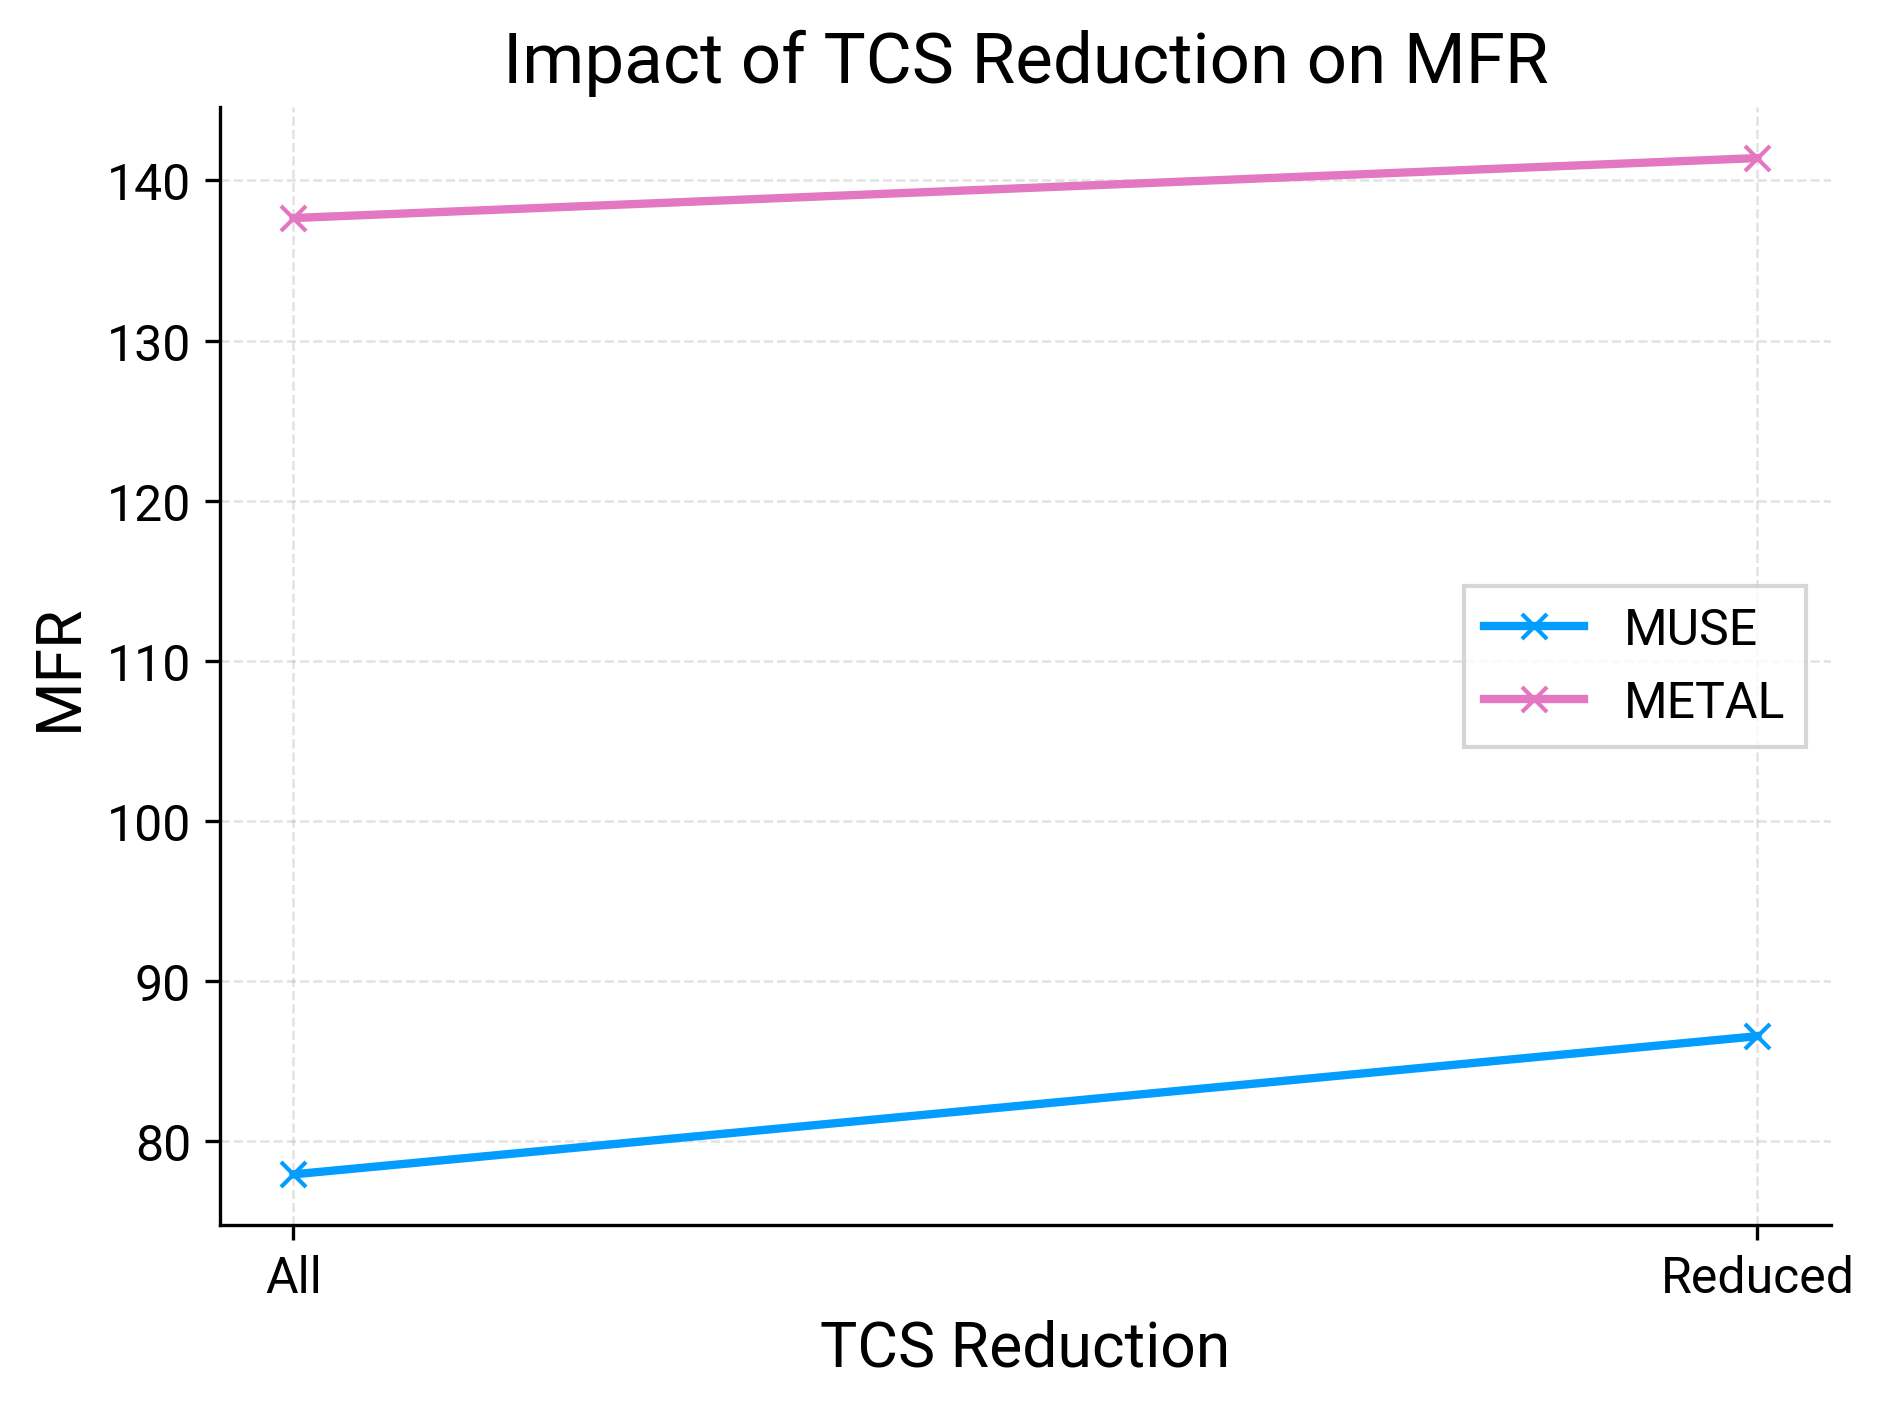

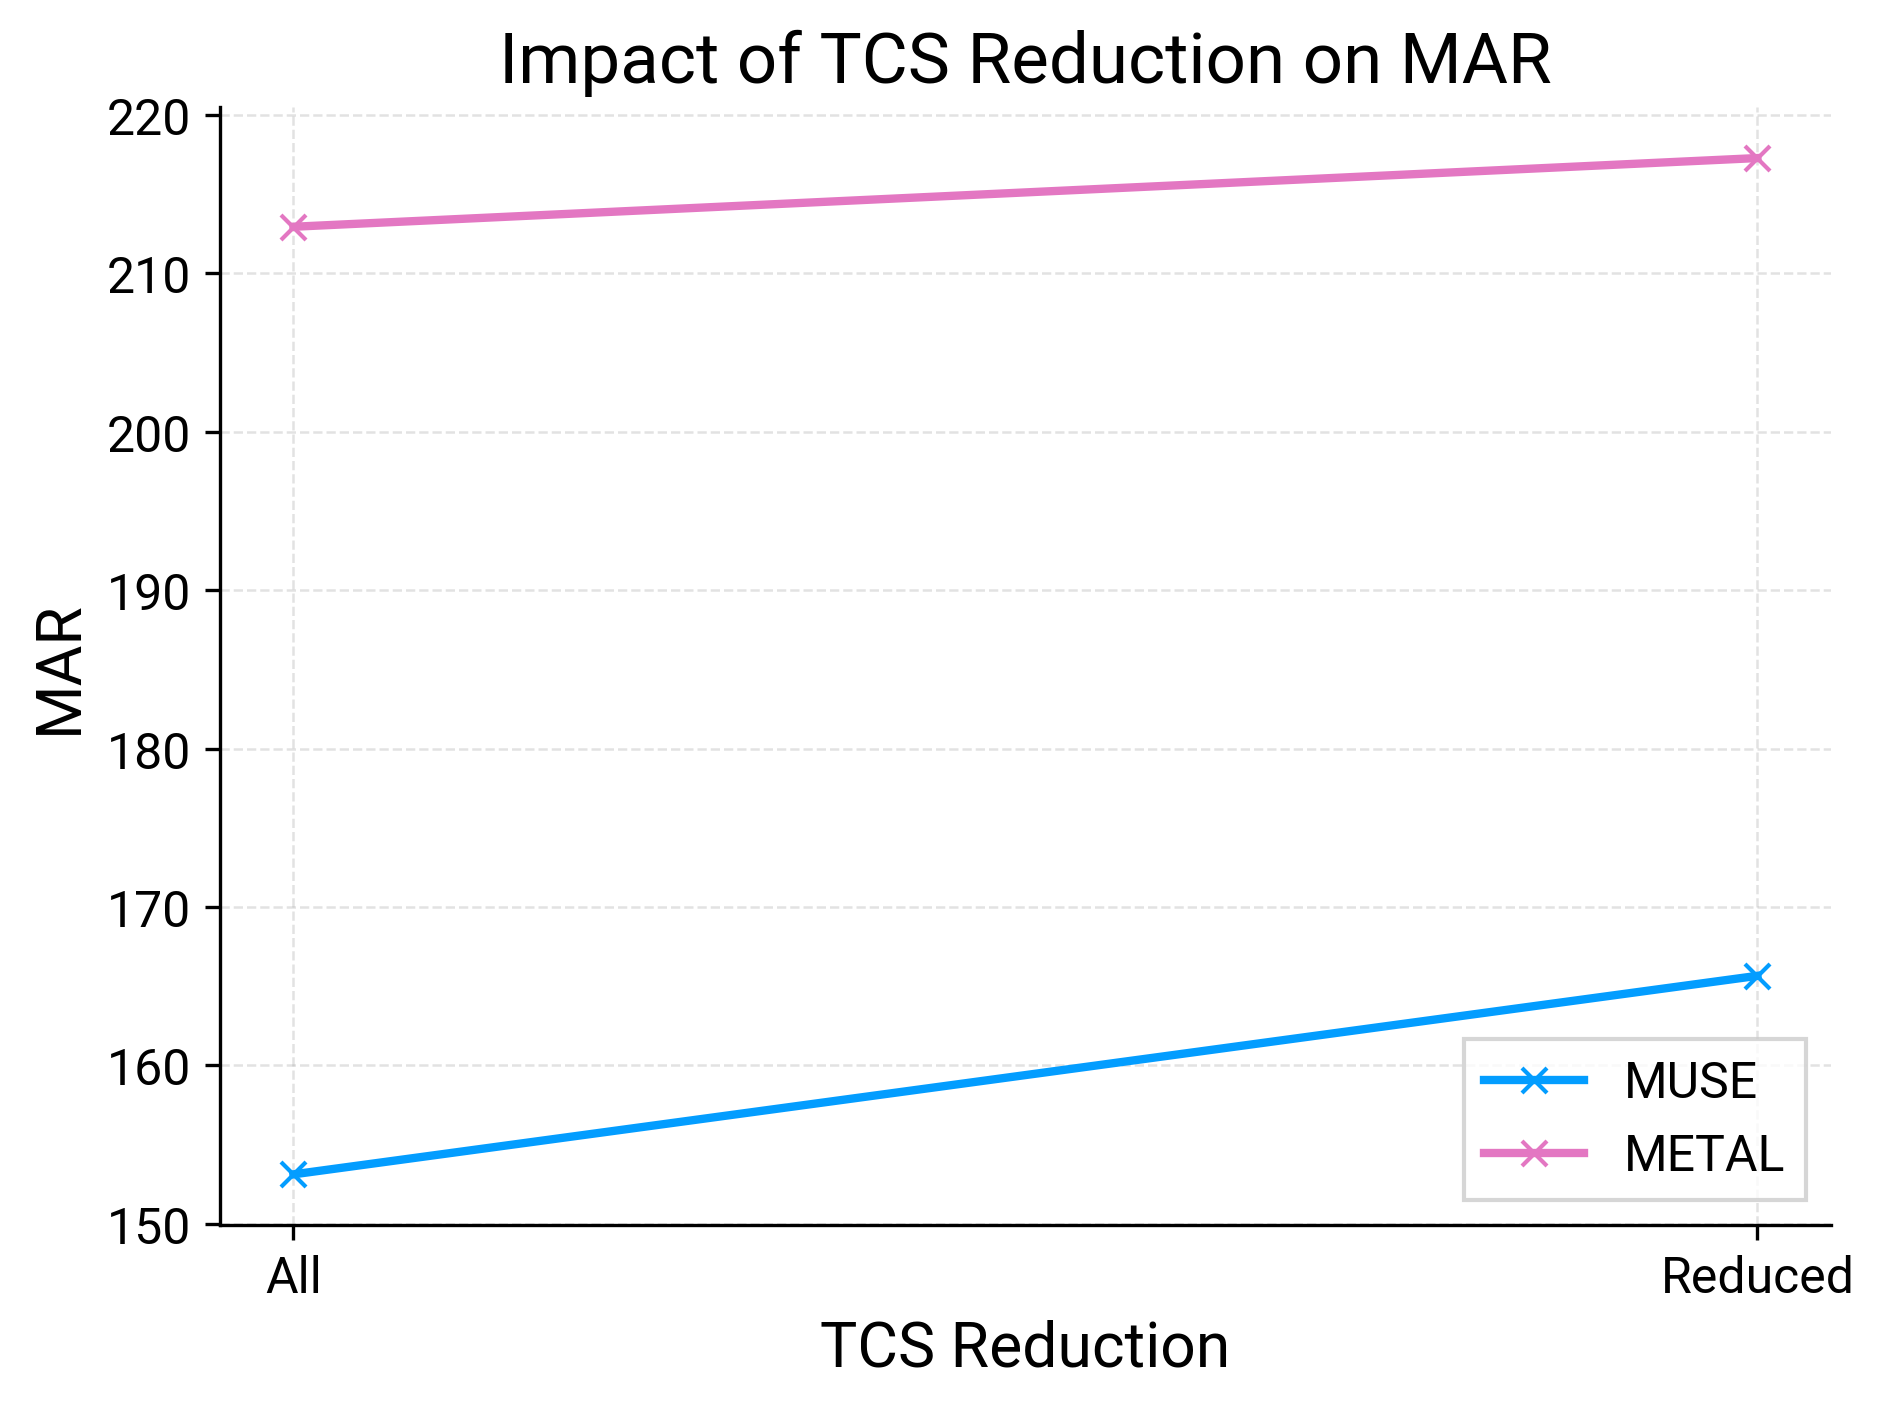

In [19]:
# for PID in PIDS:
#     print(f"\nPlotting MFR and MAR line graphs for {PID}...")
#     plot_mfr_mar_line_graphs(all_final_results[PID], PID_OUT_DIRS[PID], pid=PID, ylimit=LIM_DATA[PID],
#                              experiment_type=EXPERIMENT_TYPE,
#                              lineCnt=EXP_CONFIG["target_lines"][-1],
#                              mutCnt=EXP_CONFIG["mutation_cnt"][-1],
#                              tcsReduction=TCS_REDUCTION
#                              )


print("\nPlotting MFR and MAR line graphs for combined results...")
plot_mfr_mar_line_graphs(combined_final_results, COMBINED_OUT_DIR, pid="COMBINED",
                         ylimit=100, experiment_type=EXPERIMENT_TYPE,
                         lineCnt=EXP_CONFIG["target_lines"][-1],
                         mutCnt=EXP_CONFIG["mutation_cnt"][-1],
                         tcsReduction=TCS_REDUCTION
                         )